# Лабораторная 5. Деревья решений

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from math import sqrt, ceil, log2
from graphviz import Digraph
from IPython.display import display, Image, SVG
from sklearn.metrics import roc_curve, auc, precision_recall_curve

## Загрузка данных

In [2]:
data = pd.read_csv('data/agaricus-lepiota.data', header=None)

# Задаем названия колонок
data.columns = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color',
    'ring-number', 'ring-type', 'spore-print-color',
    'population', 'habitat'
]

## Обработка некорректных значений

In [3]:
# Заменяем '?' на NaN и удаляем строки с пропусками
data.replace('?', np.nan, inplace=True)
data.dropna(inplace=True)

## Вывод обработанных данных

In [4]:
data

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7986,e,b,y,n,f,n,f,c,b,w,...,y,n,n,p,w,t,p,w,y,p
8001,e,x,y,n,f,n,f,c,b,w,...,y,n,n,p,w,t,p,w,y,p
8038,e,x,y,g,t,n,f,c,b,w,...,s,w,w,p,w,t,p,w,y,p
8095,p,x,y,c,f,m,f,c,b,y,...,y,c,c,p,w,n,n,w,c,d


In [5]:
data.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,5644,5644,5644,5644,5644,5644,5644,5644,5644,5644,...,5644,5644,5644,5644,5644,5644,5644,5644,5644,5644
unique,2,6,4,8,2,7,2,2,2,9,...,4,7,7,1,2,3,4,6,6,6
top,e,x,y,g,t,n,f,c,b,p,...,s,w,w,p,w,o,p,n,v,d
freq,3488,2840,2220,1696,3184,2776,5626,4620,4940,1384,...,3544,3136,3088,5644,5636,5488,3488,1920,2160,2492


In [6]:
data.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

## Визуализация распределения классов в данных

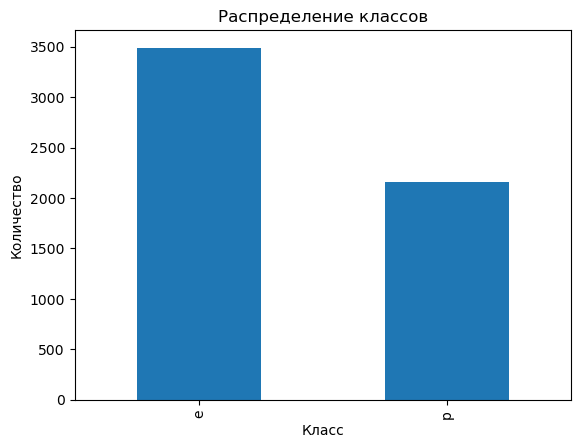

In [7]:
data['class'].value_counts().plot(kind='bar', title='Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

## Отбор случайных признаков для обучения (исключаем целевую переменную 'class')

In [8]:
columns = data.columns[1:]  # Исключаем целевую переменную
selected_columns = np.random.choice(columns, ceil(sqrt(len(columns))), replace=False)

# Подготовка данных для обучения
X = data[selected_columns]
y = data['class'].apply(lambda x: 1 if x == 'e' else 0)  # Преобразуем классы в 0 и 1

## Разделение данных на обучающую и тестовую выборки

In [9]:
def _train_test_split(X, y, seed, test_percent=0.2):
    random.seed(seed)              # seed для воспроизводимости
    indices = list(range(len(X)))  # Генерируем индексы всех примеров
    random.shuffle(indices)        # Перемешиваем индексы

    # Определяем размер тестовой выборки
    test_size = int(len(X) * test_percent)

    # Разделяем данные на обучающие и тестовые
    x_train = X.iloc[indices[test_size:]]
    x_test = X.iloc[indices[:test_size]]
    y_train = y.iloc[indices[test_size:]]
    y_test = y.iloc[indices[:test_size]]

    return x_train, x_test, y_train, y_test

## Разделяем данные на обучающие и тестовые выборки

In [10]:
seed = 373440     # ИСУ
x_train, x_test, y_train, y_test = _train_test_split(X, y, seed)

## Определяем классы узлов дерева решений

In [11]:
class Node:
    def __init__(self, feature, children):
        self.feature = feature  # Признак для разделения
        self.children = children  # Словарь: {значение признака (ребро): дочерний узел}

    def pred(self, x):
        feature_value = x[self.feature]  # Получаем значение признака для текущего примера
        if feature_value not in self.children:
            return None  # Если значения признака нет, возвращаем None
        return self.children[feature_value].pred(x)  # Рекурсивно делаем предсказание для дочернего узла


class Leaf(Node):
    def __init__(self, leaf_value, proba):
        super().__init__("", {})      # Лист не имеет признака
        self.leaf_value = leaf_value  # Значение класса в листе
        self.proba = proba            # Вероятность принадлежности к классу

    def pred(self, x):
        return self.leaf_value  # В листе возвращаем значение класса

    def predict_proba(self):
        return self.proba  # Возвращаем вероятность принадлежности к классу


class DecisionTree():
    def __init__(self, columns):
        self.columns = columns  # Колонки (признаки)
        self.root = None        # Корень дерева

    def fit(self, x, y):
        self.root = self.build_node(x[self.columns], y, self.entropy(y))  # Строим дерево
        return self.root

    def pred(self, x):
        return [self.root.pred(i) for i in x[self.columns].to_records()]  # Делаем предсказания для всех примеров

    @staticmethod
    def entropy(y):
        if len(y) == 0:
            return 0  # Возвращаем 0, если y пустой
        class_n = y.unique()  # Получаем уникальные классы
        res = 0
        for i in class_n:
            freq_i = y.value_counts().get(i, 0)
            if freq_i > 0:  # Проверяем, что freq_i больше 0
                probability = freq_i / len(y)
                res -= probability * log2(probability)
        return res
    
    def build_node(self, x, y, parent_entropy):
        # Если в выборке только один класс, возвращаем лист
        if len(y.unique()) == 1:
            return Leaf(y.unique()[0], 1)
    
        max_gain = 0
        max_gain_column = ''
    
        # Ищем лучший признак для разделения
        for column in self.columns:
            features_names = pd.unique(x[column])
            info = sum((x[column].value_counts()[feature] / len(x)) * self.entropy(y[x[column] == feature]) for feature in features_names)
    
            gain = parent_entropy - info
            if gain > max_gain:
                max_gain = gain
                max_gain_column = column
    
        # Если не найден лучший признак, создаем лист с наиболее частым классом
        if not max_gain_column:
            mode = y.mode()[0]
            return Leaf(mode, y.value_counts()[mode] / len(y))
    
        children = {}
        features_names = x[max_gain_column].unique()
        for feature in features_names:
            # Рекурсивно строим дочерние узлы
            children[feature] = self.build_node(x[x[max_gain_column] == feature], y[x[max_gain_column] == feature], self.entropy(y[x[max_gain_column] == feature]))
    
        return Node(max_gain_column, children)

y = pd.Series(['A', 'A', 'A'])  # Все экземпляры принадлежат классу 'A'
print(DecisionTree.entropy(y))  # Должно вывести 0

0.0


## Обучаем модель дерева решений

In [12]:
model = DecisionTree(selected_columns)
model.fit(x_train, y_train)

## Визуализация дерева

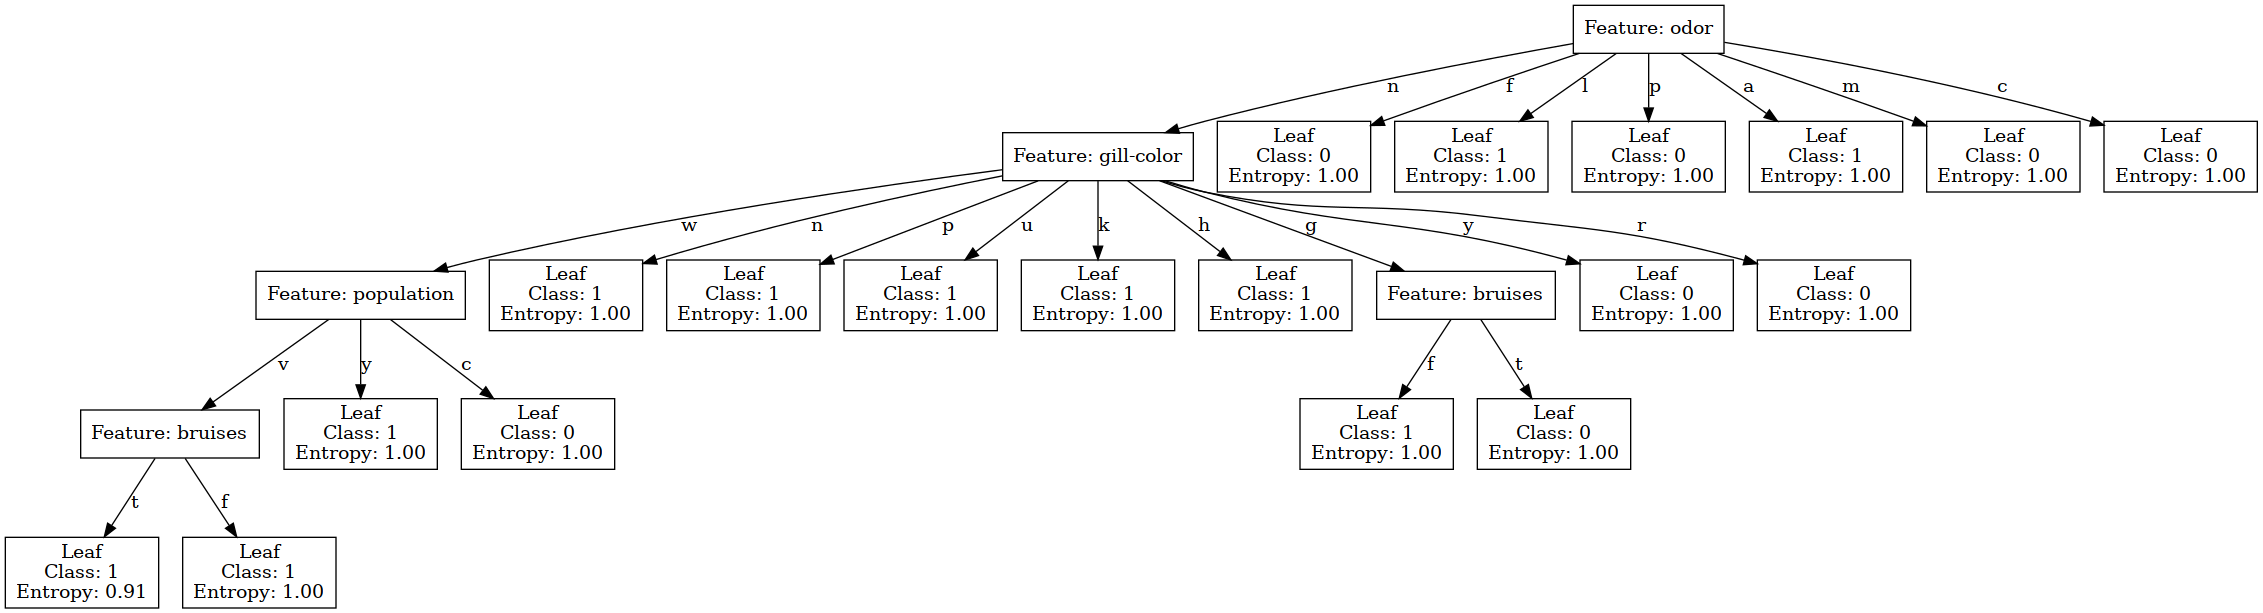

In [13]:
def visualize_tree(node, graph=None, parent_name=None, edge_label=""):
    if graph is None:
        graph = Digraph(format="png")  # Указываем формат PNG
        graph.attr("node", shape="box")

    node_name = str(id(node))  # Уникальный идентификатор для узла

    if isinstance(node, Leaf):
        # Добавляем лист с классом и вероятностью
        graph.node(node_name, label=f"Leaf\nClass: {node.leaf_value}\nEntropy: {node.proba:.2f}")
    else:
        # Добавляем узел с признаком
        graph.node(node_name, label=f"Feature: {node.feature}")
        for value, child in node.children.items():
            # Рекурсивно добавляем дочерние узлы
            visualize_tree(child, graph, node_name, edge_label=str(value))
            graph.edge(node_name, str(id(child)), label=str(value))

    return graph  # Возвращаем объект Digraph


tree_graph = visualize_tree(model.root)  # Получаем объект графа

png_data = tree_graph.pipe(format="png")  # Генерируем PNG данные
display(Image(png_data))  # Отображаем изображение

## Делаем предсказание на тестовой выборке

In [14]:
y_pred = model.pred(x_test)

## Оценка качества модели (матрица ошибок)

In [15]:
def confusion_matrix(pred_y, true_y):
    matrix = np.zeros((2, 2))
    for pred, true in zip(pred_y, true_y):
        pred = 1 if pred == 1 else 0
        true = 1 if true == 1 else 0
        matrix[pred][true] += 1
    return matrix

## Матрица ошибок

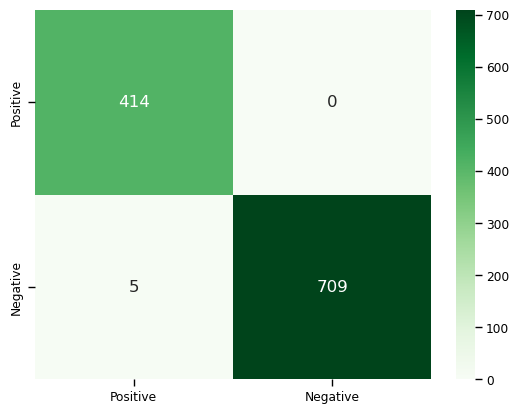

In [16]:
import seaborn as sn
cm_indeces = ['Positive', 'Negative']
df_cm = pd.DataFrame(confusion_matrix(y_pred, y_test), index = cm_indeces, columns = cm_indeces)
sn.set_context("paper", rc={"font.size":12,"axes.titlesize":8,"axes.labelsize":5})
sn.heatmap(df_cm, annot=True, fmt='.0f', cmap="Greens")
plt.show()

## Функции для расчета метрик

In [17]:
# Оценка качества модели
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def precision(cm):
    return cm[1][1] / (cm[1][1] + cm[0][1]) if (cm[1][1] + cm[0][1]) != 0 else 0

def recall(cm):
    return cm[1][1] / (cm[1][1] + cm[1][0]) if (cm[1][1] + cm[1][0]) != 0 else 0

def tpr(cm):
    return recall(cm)

def fpr(cm):
    return cm[1][0] / (cm[1][0] + cm[0][0])

## Метрики

In [18]:
cm = confusion_matrix(y_test, y_pred)

print("Accuracy (верные предсказания):", accuracy(y_test, y_pred))
print("Precision (действительно положительные среди верных предсказаний):", precision(cm))
print("Recall (правильно идентифицированы моделью):", recall(cm))

Accuracy (верные предсказания): 0.9955673758865248
Precision (действительно положительные среди верных предсказаний): 0.9929971988795518
Recall (правильно идентифицированы моделью): 1.0


## AUC-ROC и AUC-PR

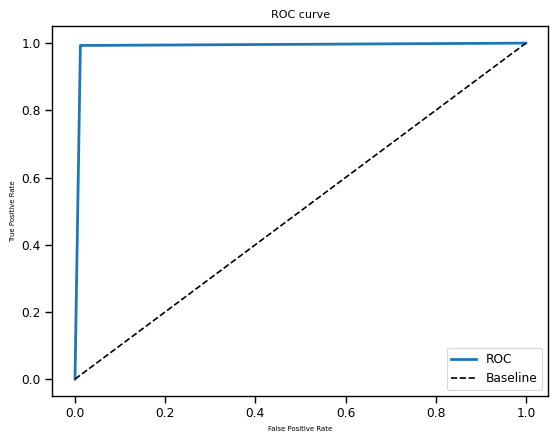

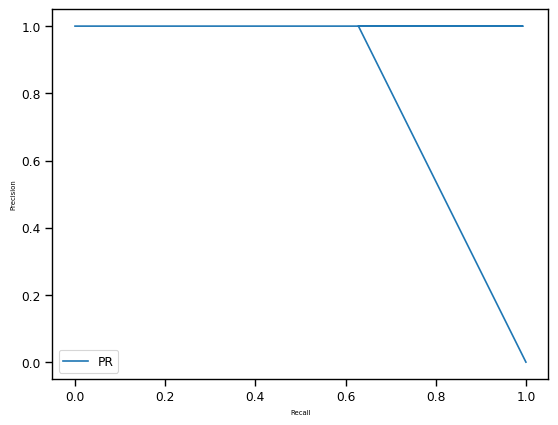

In [19]:
def confusion_matrix_proba(y_pred_proba, true_y, threshold):
    matrix = np.zeros((2, 2))
    for pred_prob, true in zip(y_pred_proba, true_y):
        pred = 1 if pred_prob >= threshold else 0
        true = 1 if true == 1 else 0
        matrix[pred][true] += 1
    return matrix


def auc_roc_plot(y_pred_proba):
    tpr_arr = []
    fpr_arr = []
    for th in np.arange(0.01, 1, 0.01):  # шаг уменьшается
        conf = confusion_matrix_proba(y_pred_proba, y_test, th)
        tpr_arr.append(tpr(conf))
        fpr_arr.append(fpr(conf))
    plt.plot([0] + fpr_arr + [1], [0] + tpr_arr + [1], lw=2, label='ROC')
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'k--', label='Baseline')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

auc_roc_plot(y_pred)


def auc_pr_plot(y_pred_proba):
  p = []
  r = []

  for th in np.arange(0, 1, 0.01):
    conf = confusion_matrix_proba(y_pred_proba, y_test, th)
    p.append(precision(conf))
    r.append(recall(conf))

  plt.plot([1] + r + [0], [0] + p + [1], label='PR')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()

auc_pr_plot(y_pred)